## COVID-19 PAKISTAN Data Modeling

### Packages

In [1]:
import numpy as np
import pandas as pd
import datetime
import math
from pandas import read_excel
from scipy.optimize import minimize
#Import matplotlib
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
#plt.style.use('fivethirtyeight')
%matplotlib inline

# Import Prophet
import plotly.offline as py
#import plotly.express as px
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, add_changepoints_to_plot
from datetime import datetime, timedelta

import logging
logging.getLogger('fbprophet').setLevel(logging.WARNING)
# hide warnings
import warnings
warnings.filterwarnings('ignore')


#### National Data Model: 

In [2]:
# Read  data file
full_table = pd.read_excel('F:/Data Sets/COVID-19/Pakistan/time series/COVID-19_DATA.xlsx',sheet_name='TimeSeries_KeyIndicators')
# Add Active Cases count
full_table['Active'] = full_table['Cumulative  Test positive'] - full_table['Expired'] - full_table['Discharged']
# Set Date into Pandas date format
full_table['Date'] = pd.to_datetime(full_table['Date'])
# Rename data frame columns
fulltable = full_table.rename(columns={"Cumulative  Test positive": "Confirmed", 
                                       "Expired": "Deaths","Discharged": "Recovered"})


In [3]:
fulltable['Date'] = pd.to_datetime(fulltable['Date'])

In [4]:
# latest condensed
full_latest = fulltable[fulltable['Date'] == max(fulltable['Date'])].reset_index()
full_table_grouped = full_latest.groupby('Region')['Confirmed', 'Deaths', 'Recovered', 'Active'].sum().reset_index()

In [5]:
temp_f = full_table_grouped.sort_values(by='Confirmed', ascending=False)
temp_f = temp_f[['Region', 'Confirmed', 'Active', 'Deaths', 'Recovered']]
temp_f = temp_f.reset_index(drop=True)
temp_f["Mortality Rate (per 100)"] = np.round(100*temp_f["Deaths"]/temp_f["Confirmed"],2)
temp_f.style.background_gradient(cmap="Reds", subset=['Confirmed'])\
            .background_gradient(cmap="Greens", subset=['Recovered'])\
            .background_gradient(cmap="Greys", subset=['Deaths'])\
            .background_gradient(cmap="Blues", subset=['Active'])\
            .background_gradient(cmap='YlOrBr',subset=["Mortality Rate (per 100)"])


,Region,Confirmed,Active,Deaths,Recovered,Mortality Rate (per 100)
0,Sindh,71092,32945,1103,37044,1.550000
1,Punjab,68308,47233,1495,19580,2.190000
2,KP,22633,14921,843,6869,3.720000
3,ICT,11219,6101,106,5012,0.940000
4,Balochistan,9587,5813,104,3670,1.080000
5,GB,1326,358,22,946,1.660000
6,AJK,869,497,22,350,2.530000


In [6]:
df = fulltable[['Region', 'Date', 'Confirmed', 'Deaths']].groupby('Date').sum()
print('Pakistan COVID-19')
df.tail(15)

Pakistan COVID-19


,Confirmed,Deaths
Date,,
2020-06-08,108317,2172
2020-06-09,113702,2255
2020-06-10,119536,2356
2020-06-11,125933,2463
2020-06-12,132405,2551
2020-06-13,139230,2632
2020-06-14,144478,2729
2020-06-15,148921,2839
2020-06-16,154760,2975


## Diffusion Process with Gradient Descent

In [7]:
import math
def model_with_lag(N, a, alpha, lag, t):
    # we enforce N, a and alpha to be positive numbers using min and max functions
    lag = min(max(lag, -100), 100) # lag must be less than +/- 100 days 
    return max(N, 0) * (1 - math.e ** (min(-a, 0) * (t - lag))) ** max(alpha, 0)

def model(N, a, alpha, t):
    return max(N, 0) * (1 - math.e ** (min(-a, 0) * t)) ** max(alpha, 0)

In [8]:
model_index = 0

def model_loss(params):
#     N, a, alpha, lag = params
    N, a, alpha = params
    model_x = []
    r = 0
    for t in range(len(df)):
        r += (model(N, a, alpha, t) - df.iloc[t, model_index]) ** 2
    return math.sqrt(r) 


We need to explore the 3d parameter space to find a minimum, using __gradient descent__. There are a number of algorithms to do that in scipy.optimize, I stopped at the first one that seemed to work. __Generalized Reduced Gradient__ as in Excel solver also works.

__Minimize Model Loss__ 

In [9]:
# opt_display_model

from scipy.optimize import minimize
use_lag_model = False
if use_lag_model:
    opt = minimize(model_loss, x0=np.array([200000, 0.05, 15, 0]), method='Nelder-Mead', tol=1e-5).x
else:
    model_index = 0
    opt_confirmed = minimize(model_loss, x0=np.array([200000, 0.05, 15]), method='Nelder-Mead', tol=1e-5).x
    model_index = 1
    opt_deaths = minimize(model_loss, x0=np.array([200000, 0.05, 15]), method='Nelder-Mead', tol=1e-5).x

### Plot_FIT_Confirmed_Count

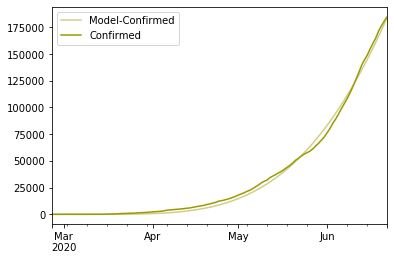

In [10]:

model_x = []
for t in range(len(df)):
    model_x.append([df.index[t], model(*opt_confirmed, t)])
model_sim = pd.DataFrame(model_x, dtype=int)
model_sim.set_index(0, inplace=True)
model_sim.columns = ['Model-Confirmed']

plot_color = ['#99990077','#999900FF']

pd.concat([model_sim, df['Confirmed']], axis=1).plot(color = plot_color)
plt.show()

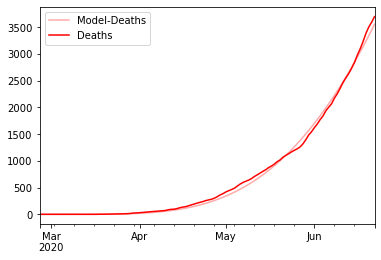

In [11]:

model_x = []
for t in range(len(df)):
    model_x.append([df.index[t], model(*opt_deaths, t)])
model_sim = pd.DataFrame(model_x, dtype=int)
model_sim.set_index(0, inplace=True)
model_sim.columns = ['Model-Deaths']

plot_color = ['#FF000055', '#FF0000FF']

pd.concat([model_sim, df['Deaths']], axis=1).plot(color = plot_color)
plt.show()

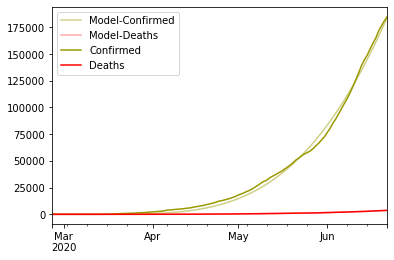

In [12]:

model_x = []
for t in range(len(df)):
    model_x.append([df.index[t], model(*opt_confirmed, t), model(*opt_deaths, t)])
model_sim = pd.DataFrame(model_x, dtype=int)
model_sim.set_index(0, inplace=True)
model_sim.columns = ['Model-Confirmed', 'Model-Deaths']

plot_color = ['#99990077', '#FF000055', '#999900FF', '#FF0000FF']

pd.concat([model_sim, df], axis=1).plot(color = plot_color)
plt.show()

Pakistan COVID-19 Prediction


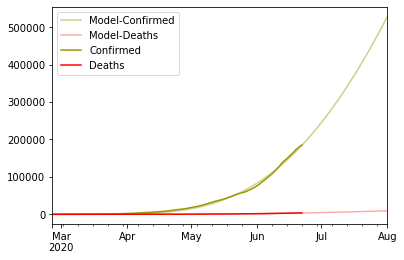

In [13]:
import datetime

start_date = df.index[0]
n_days = len(df) + 40
extended_model_x = []
last_row = []

isValid = True
last_death_rate = 0

for t in range(n_days):
    extended_model_x.append([start_date + datetime.timedelta(days=t), model(*opt_confirmed, t), model(*opt_deaths, t)])
    
        #if deaths + recovered > confirmed or deaths rate > 5%, maybe not valid
    if (t > len(df)):
        last_row = extended_model_x[-1]
        if (last_row[2] > last_row[1]*0.05):
            if (isValid):
                last_row2 = extended_model_x[-2]
                last_death_rate = last_row2[2]/last_row2[1]
                isValid = False
            
        if (last_row[2] > last_row[1]*0.05):
            last_row[2] = last_row[1]*last_death_rate

extended_model_sim = pd.DataFrame(extended_model_x, dtype=int)
extended_model_sim.set_index(0, inplace=True)
extended_model_sim.columns = ['Model-Confirmed', 'Model-Deaths']

plot_color = ['#99990077', '#FF000055', '#999900FF', '#FF0000FF']
plot_color_c = ['#99990077', '#999900FF']
pd.concat([extended_model_sim, df], axis=1).plot(color = plot_color)
print('Pakistan COVID-19 Prediction')
#pd.concat([extended_model_sim['Model-Confirmed'], df['Confirmed']], axis=1).plot(color = plot_color_c)
plt.show()

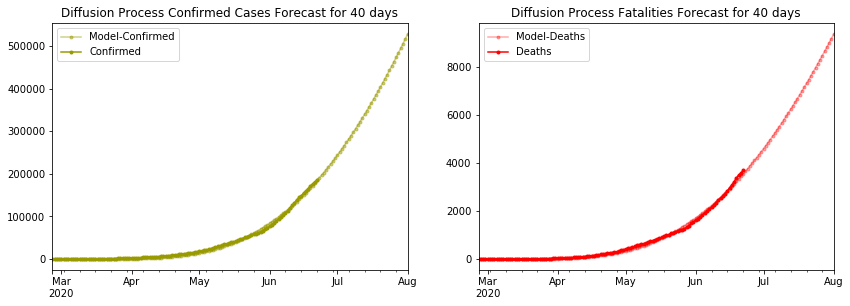

In [15]:
plot_color = ['#99990077', '#FF000055', '#999900FF', '#FF0000FF']
plot_color_c = ['#99990077', '#999900FF']
plot_color_d = ['#FF000055', '#FF0000FF']
plt.figure(1)
ax1 = plt.subplot(221)
pd.concat([extended_model_sim['Model-Confirmed'], df['Confirmed']], axis=1).plot(linestyle = '-', marker = '.',figsize=(14, 10), color = plot_color_c, ax=ax1, title = 'Diffusion Process Confirmed Cases Forecast for 40 days')
ax2 = plt.subplot(222)
pd.concat([extended_model_sim['Model-Deaths'], df['Deaths']], axis=1).plot(linestyle = '-', marker = '.', figsize=(14, 10), color = plot_color_d, ax=ax2, title = 'Diffusion Process Fatalities Forecast for 40 days')
plt.show()

## ARIMA

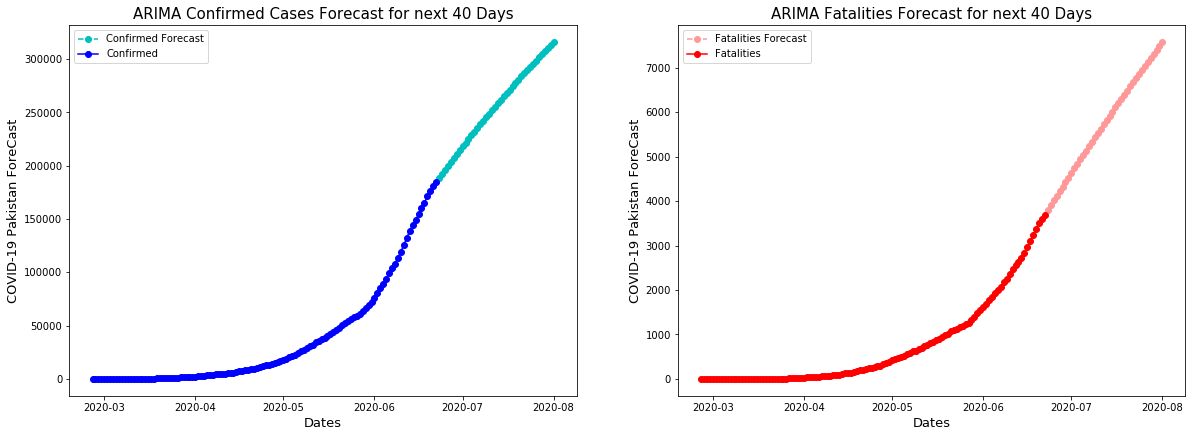

In [19]:
import datetime
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.filterwarnings('ignore')

global fulltable

predgrp = fulltable.groupby("Date")[["Confirmed","Recovered","Deaths"]].sum().reset_index()
# Confirm Cases
pred_cnfrm = predgrp.loc[:,["Date","Confirmed"]]
pred_cnfrm['Date'] = pd.to_datetime(pred_cnfrm['Date'])
pr_data_c = pred_cnfrm
pr_data_c.columns = ['ds','y']
# Model Confirm
arima_c = ARIMA(pr_data_c['y'], order=(5, 1, 0))
arima_c = arima_c.fit(trend='c', full_output=True, disp=True)
forecast_c = arima_c.forecast(steps= 40)
pred_c = list(forecast_c[0])

# Expired Cases
pred_exp = predgrp.loc[:,["Date","Deaths"]]
pr_data_e = pred_exp
pr_data_e.columns = ['ds','y']

arima_e = ARIMA(pr_data_e['y'], order=(5, 1, 0))
arima_e = arima_e.fit(trend='c', full_output=True, disp=True)
forecast_e = arima_e.forecast(steps= 40)
pred_e = list(forecast_e[0])

# Recovered Cases
pred_rec = predgrp.loc[:,["Date","Recovered"]]
pr_data_r = pred_rec
pr_data_r.columns = ['ds','y']
# Model
arima_r = ARIMA(pr_data_r['y'], order=(5, 1, 0))
arima_r = arima_r.fit(trend='c', full_output=True, disp=True)
forecast_r = arima_r.forecast(steps= 40)
pred_r = list(forecast_r[0])

# Plot Forecast
start_date = pr_data_c['ds'].max() 
prediction_dates = []
for i in range(40):
    date = start_date + datetime.timedelta(days=1)
    prediction_dates.append(date)
    start_date = date

plt.figure(figsize= (20,15))
ax1 = plt.subplot(221)
ax1.plot_date(y= pred_c,x= prediction_dates,linestyle ='dashed',color = 'c' , label = 'Confirmed Forecast');
ax1.plot_date(y=pr_data_c['y'],x=pr_data_c['ds'],linestyle = '-',color = 'b' , label = 'Confirmed');
ax1.set_title("ARIMA Confirmed Cases Forecast for next 40 Days" , fontsize = 15)
ax1.set_xlabel("Dates",fontsize = 13) 
ax1.set_ylabel('COVID-19 Pakistan ForeCast',fontsize = 13) 
ax1.legend()
ax2 = plt.subplot(222)
ax2.plot_date(y= pred_e,x= prediction_dates,linestyle ='dashed',color = '#ff9999',label = 'Fatalities Forecast');
ax2.plot_date(y=pr_data_e['y'],x=pr_data_e['ds'],linestyle = '-',color = 'r',label = 'Fatalities');
ax2.set_title("ARIMA Fatalities Forecast for next 40 Days" , fontsize = 15)
ax2.set_xlabel("Dates",fontsize = 13) 
ax2.set_ylabel('COVID-19 Pakistan ForeCast',fontsize = 13) 
ax2.legend();

## PROPHET

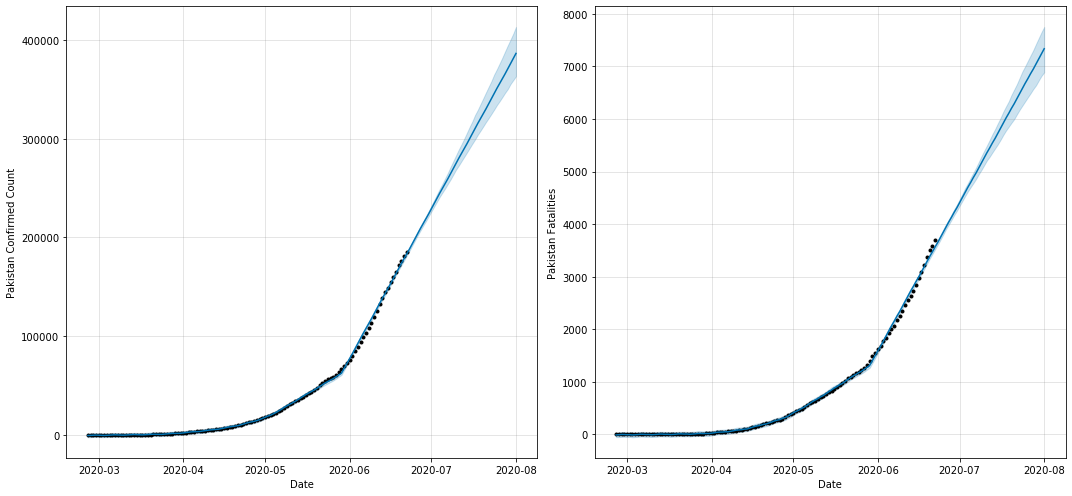

In [17]:
global fulltable

predgrp = fulltable.groupby("Date")[["Confirmed","Recovered","Deaths"]].sum().reset_index()
pred_cnfrm = predgrp.loc[:,["Date","Confirmed"]]
pred_exp = predgrp.loc[:,["Date","Deaths"]]

c_data = pred_cnfrm
e_data = pred_exp

c_data.columns = ['ds','y']
e_data.columns = ['ds','y']

# Confirm Count
mc = Prophet(daily_seasonality=True)
mc.fit(c_data)
future_c = mc.make_future_dataframe(periods=40)
forecast_c = mc.predict(future_c)
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(15,7))
#py.init_notebook_mode()
fig1 = mc.plot(forecast_c,xlabel='Date',ylabel='Pakistan Confirmed Count', ax=ax1)
# Detecting Trend Change ponits
#add_changepoints_to_plot(fig1.gca(), mc, forecast_c)

# Expiry Count
me = Prophet(daily_seasonality=True)
me.fit(e_data)
future_e = me.make_future_dataframe(periods=40)
forecast_e = me.predict(future_e)
#py.init_notebook_mode()
fig2 = me.plot(forecast_e,xlabel='Date',ylabel='Pakistan Fatalities',ax=ax2)
# Detecting Trend Change ponits
#a2 = add_changepoints_to_plot(fig2.gca(), me, forecast_e)


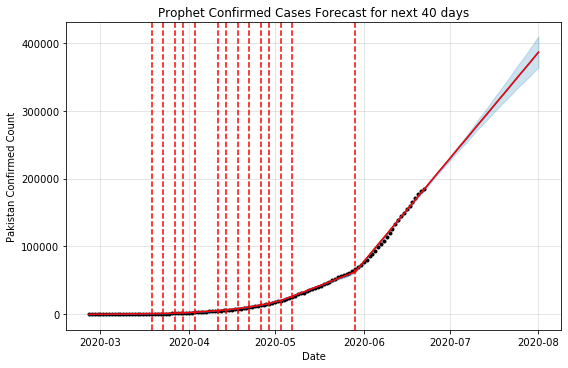

In [23]:
# Confirm Count
mc = Prophet(daily_seasonality=True)
mc.fit(c_data)
future_c = mc.make_future_dataframe(periods=40)
forecast_c = mc.predict(future_c)
#py.init_notebook_mode()
fig1 = mc.plot(forecast_c,xlabel='Date',ylabel='Pakistan Confirmed Count', figsize=(8,5))
axes = fig1.get_axes()
axes[0].set_title('Prophet Confirmed Cases Forecast for next 40 days', size=12)
# Detecting Trend Change ponits
a = add_changepoints_to_plot(fig1.gca(), mc, forecast_c)

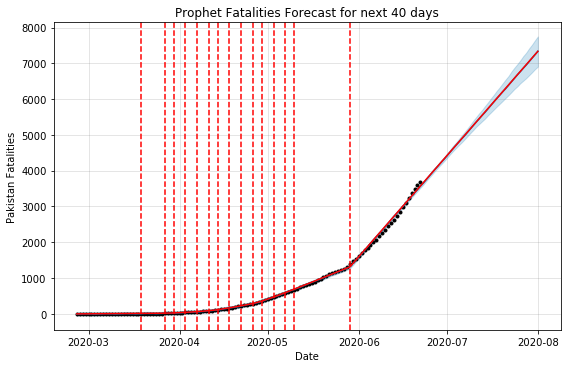

In [22]:
# Expiry Count
me = Prophet(daily_seasonality=True)
me.fit(e_data)
future_e = me.make_future_dataframe(periods=40)
forecast_e = me.predict(future_e)
#py.init_notebook_mode()
fig1 = me.plot(forecast_e,xlabel='Date',ylabel='Pakistan Fatalities', figsize=(8,5))
axes = fig1.get_axes()
axes[0].set_title('Prophet Fatalities Forecast for next 40 days', size=12)
# Detecting Trend Change ponits
a = add_changepoints_to_plot(fig1.gca(), me, forecast_e)

__National Confirmed Cases Forecast__

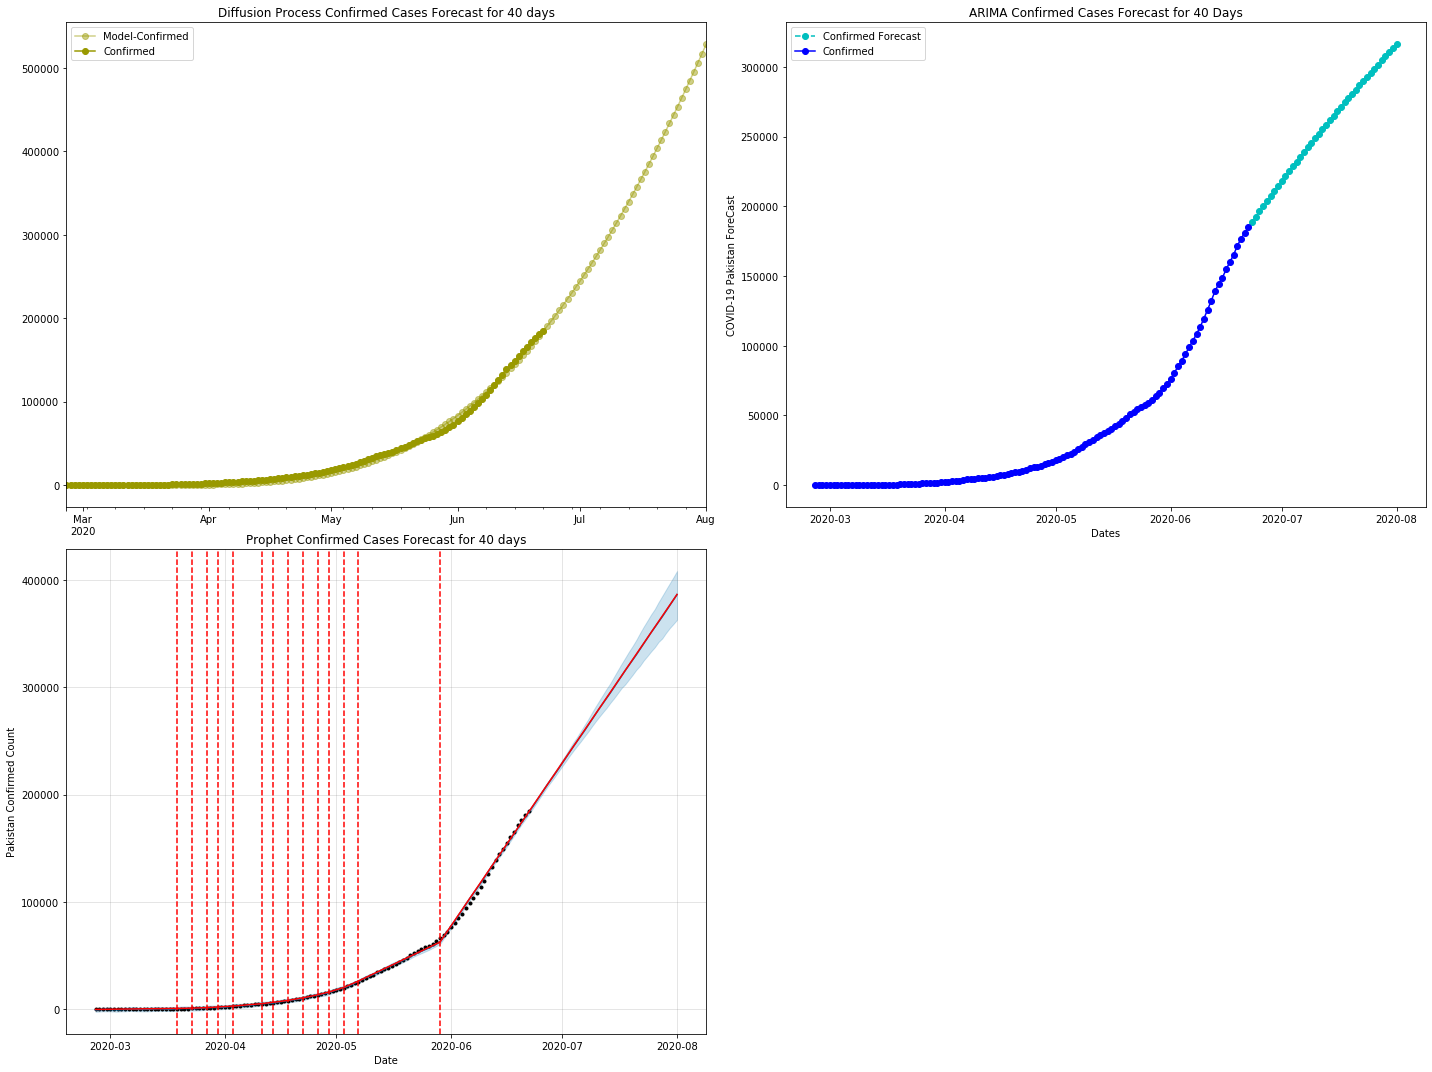

In [25]:
#plot_color_c = ['c', 'b']
plot_color_c = ['#99990077', '#999900FF']
plot_color_d = ['#FF000055', '#FF0000FF']
linestyle = ['-','--']
plt.figure(figsize= (20,15))
plt.figure(1)

ax1 = plt.subplot(221)
pd.concat([extended_model_sim['Model-Confirmed'], df['Confirmed']], axis=1).plot(linestyle='-',  color = plot_color_c, ax=ax1, title = 'Diffusion Process Confirmed Cases Forecast for 40 days', marker='o')
ax2 = plt.subplot(222)
#ax2.plot(pd.to_datetime(pr_data_c['ds']),pr_data_c['y'], linestyle = '-',color = 'b' , label = 'Confirmed' )
#ax2.plot(pd.to_datetime(prediction_dates), pred_c, linestyle ='--',color = 'c' , label = 'Confirmed Forecast') 
ax2.plot_date(y= pred_c,x= pd.to_datetime(prediction_dates),linestyle ='dashed',color = 'c' , label = 'Confirmed Forecast');
ax2.plot_date(y=pr_data_c['y'],x=pd.to_datetime(pr_data_c['ds']),linestyle = '-',color = 'b' , label = 'Confirmed');
ax2.xaxis_date()
ax2.set_title("ARIMA Confirmed Cases Forecast for 40 Days" , fontsize = 12)
ax2.set_xlabel("Dates",fontsize = 10) 
ax2.set_ylabel('COVID-19 Pakistan ForeCast',fontsize = 10) 
ax2.legend()

ax3 = plt.subplot(223)
mc = Prophet(daily_seasonality=True)
mc.fit(c_data)
future_c = mc.make_future_dataframe(periods=40)
forecast_c = mc.predict(future_c)
#py.init_notebook_mode()
fig1 = mc.plot(forecast_c,xlabel='Date',ylabel='Pakistan Confirmed Count', ax=ax3)
axes = fig1.get_axes()
axes[2].set_title('Prophet Confirmed Cases Forecast for 40 days', size=12)
a = add_changepoints_to_plot(fig1.gca(), mc, forecast_c)


__National Fatalities Forecast__

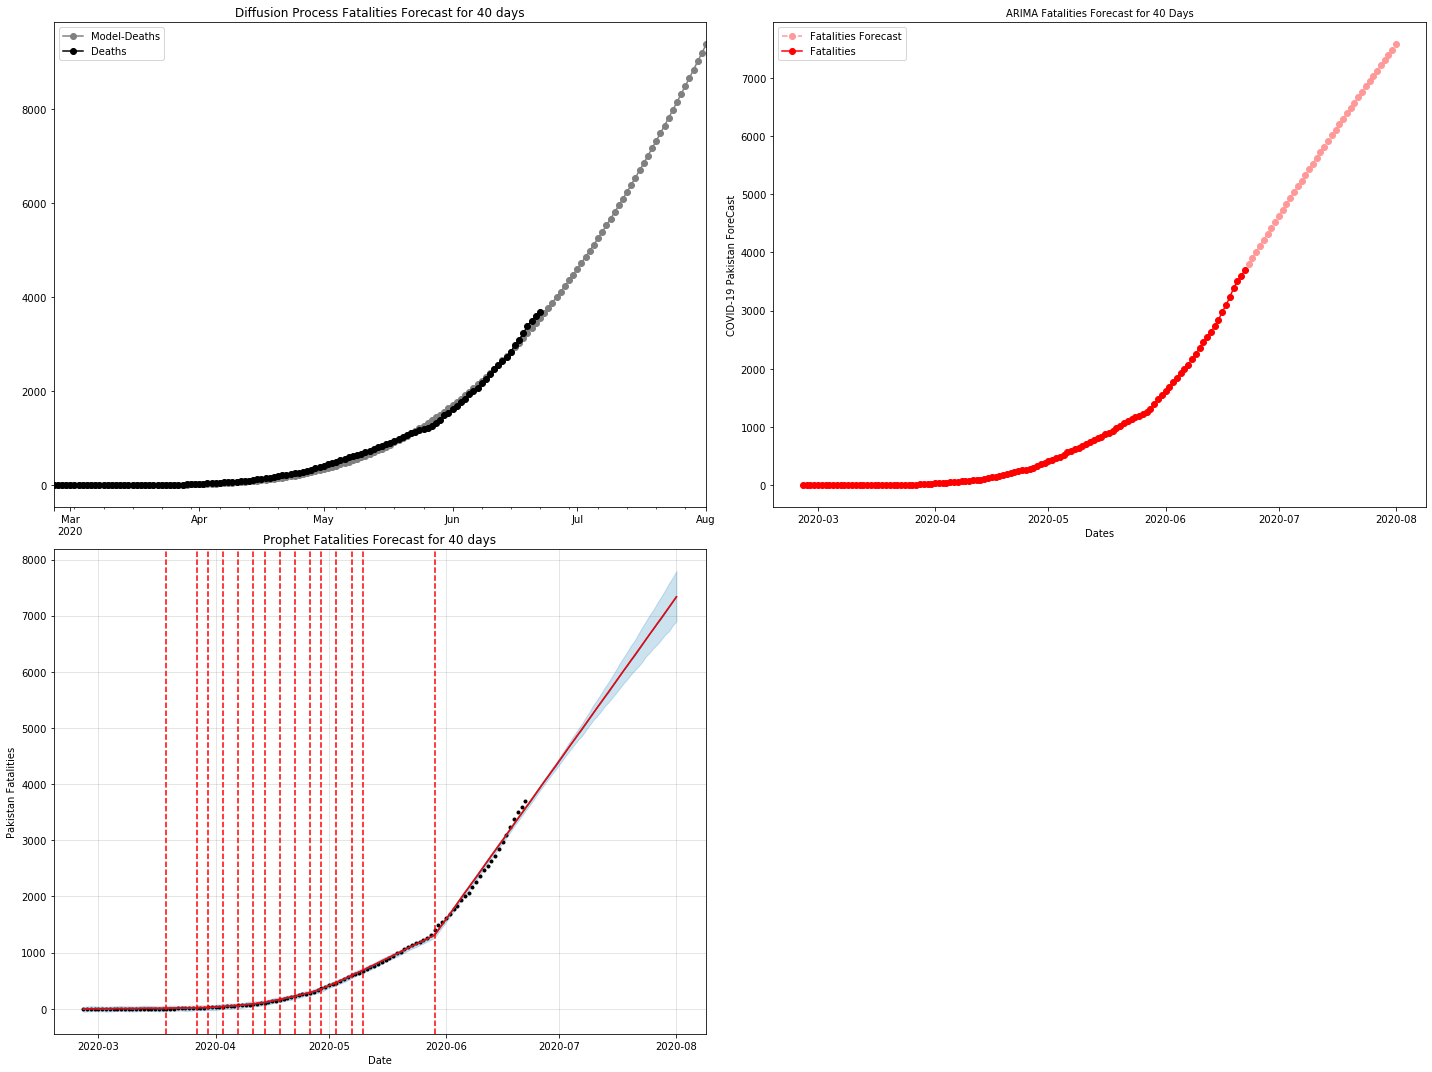

In [26]:

plot_color_d = ['grey', '#000000']
linestyle = ['-','--']
plt.figure(figsize= (20,15))
plt.figure(1)
ax1 = plt.subplot(221)
pd.concat([extended_model_sim['Model-Deaths'], df['Deaths']], axis=1).plot(marker='o',color = plot_color_d, ax=ax1, title = 'Diffusion Process Fatalities Forecast for 40 days')

ax2 = plt.subplot(222)
#ax2.plot(pd.to_datetime(pr_data_c['ds']),pr_data_c['y'], linestyle = '-',color = 'b' , label = 'Confirmed' )
#ax2.plot(pd.to_datetime(prediction_dates), pred_c, linestyle ='--',color = 'c' , label = 'Confirmed Forecast') 
ax2.plot_date(y= pred_e,x= prediction_dates,linestyle ='dashed',color = '#ff9999',label = 'Fatalities Forecast');
ax2.plot_date(y=pr_data_e['y'],x=pd.to_datetime(pr_data_e['ds']),linestyle = '-',color = 'r',label = 'Fatalities');
ax2.set_title("ARIMA Fatalities Forecast for 40 Days" , fontsize = 10)
ax2.set_xlabel("Dates",fontsize = 10) 
ax2.set_ylabel('COVID-19 Pakistan ForeCast',fontsize = 10) 
ax2.legend();

ax3 = plt.subplot(223)
me = Prophet(daily_seasonality=True)
me.fit(e_data)
future_e = me.make_future_dataframe(periods=40)
forecast_e = me.predict(future_e)
#py.init_notebook_mode()
fig1 = me.plot(forecast_e,xlabel='Date',ylabel='Pakistan Fatalities', ax=ax3)
axes = fig1.get_axes()
axes[2].set_title('Prophet Fatalities Forecast for 40 days', size=12)
# Detecting Trend Change ponits
a = add_changepoints_to_plot(fig1.gca(), me, forecast_e)


__Prediction Tables__

In [27]:
#-----------ARIMA
#print(c_data['y'], pred_c)
# concat_df = pd.concat([df, pred_c], axis=1)
# concat_df
dates = pd.to_datetime(prediction_dates)
dates = pd.DataFrame(dates)
dates.columns = ['Dates']
dates
ar_c = pd.DataFrame(pred_c)
ar_c.columns = ['ARIMA_Confirmed']
ar_c
ar_e = pd.DataFrame(pred_e, dtype=int)
ar_e.columns = ['ARIMA_Deaths']
ar_e

#extended_model_ar = pd.DataFrame(dates, pred_c, dtype=int)
#extended_model_ar.set_index(0, inplace=True)
#extended_model_ar.columns = ['ARIMA-Confirmed']
#extended_model_ar

#pr_data_c['y']
concat_ar = pd.concat([dates, ar_c, ar_e ], axis=1)
#concat_ar

In [38]:
#----- Diffusion
pd.options.display.float_format = '{:20,.0f}'.format
concat_dg = pd.concat([df, extended_model_sim], axis=1)
concat_dg = concat_dg.tail(40)
con_dg = pd.DataFrame(concat_dg)
con_dg = con_dg.drop(['Confirmed','Deaths'], axis=1)
#----------------#
con = con_dg.reset_index()
con = con.drop('index',axis=1)
diff_g = con.rename(columns={"Model-Confirmed": "Diffusion-Confirmed", 
                                       "Model-Deaths": "Diffusion-Deaths"})
#diff_g


In [39]:
#forecast_c.tail(15)
#forecast_e.tail(15)

In [40]:
#--- Prophet
pr_c = forecast_c['yhat_upper'].tail(40)
pr_cf = pr_c.reset_index()
pr_cf = pr_cf.drop('index', axis=1)
pr_cf = pr_cf.rename(columns = {"yhat_upper":"Prophet_Confirmed"})
pr_cf

pr_e = forecast_e['yhat_upper'].tail(40)
pr_ef = pr_e.reset_index()
pr_ef = pr_ef.drop('index', axis=1)
pr_ef = pr_ef.rename(columns = {"yhat_upper":"Prophet_Deaths"})
#pr_ef

In [41]:
concat_df = pd.concat([dates, ar_c, ar_e, diff_g, pr_cf, pr_ef], axis=1)
concat_df

,Projection_Dates,ARIMA_Confirmed,ARIMA_Deaths,Diffusion-Confirmed,Diffusion-Deaths,Prophet_Confirmed,Prophet_Deaths
0,2020-06-23,"188,857",3800,"190,570","3,660","190,325","3,699"
1,2020-06-24,"192,675",3906,"196,823","3,771","195,529","3,793"
2,2020-06-25,"196,397",4012,"203,202","3,884","200,731","3,891"
3,2020-06-26,"200,101",4116,"209,706","3,999","206,248","3,993"
4,2020-06-27,"203,781",4220,"216,336","4,116","211,280","4,089"
5,2020-06-28,"207,417",4323,"223,092","4,235","216,296","4,182"
6,2020-06-29,"211,030",4426,"229,975","4,356","221,364","4,281"
7,2020-06-30,"214,612",4528,"236,984","4,478","226,384","4,369"
8,2020-07-01,"218,164",4630,"244,121","4,603","232,107","4,470"
9,2020-07-02,"221,689",4732,"251,385","4,729","237,357","4,577"


## SARIMA

Text(0, 0.5, 'Fatalities')

<Figure size 432x288 with 0 Axes>

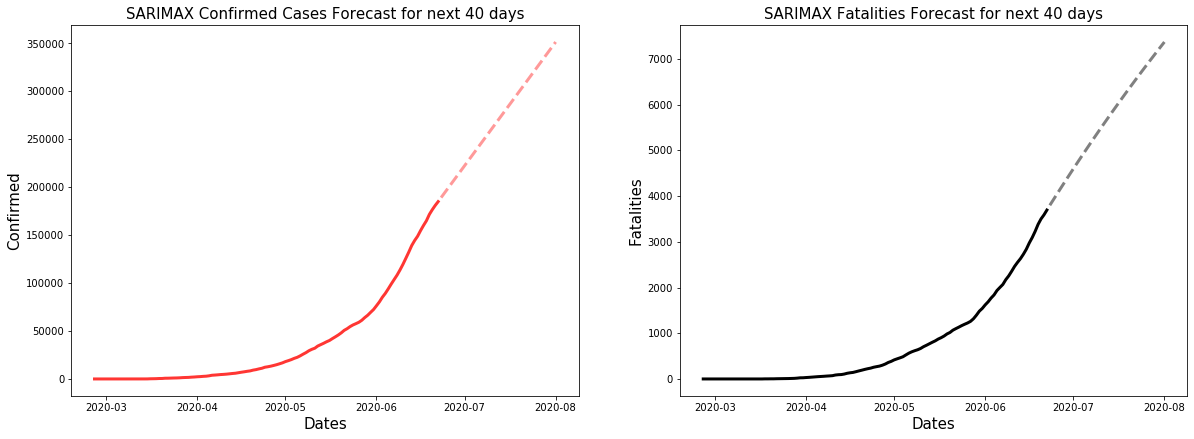

In [42]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
#plt.style.use('fivethirtyeight')
%matplotlib inline
global fulltable
# SARIMA Confirmed
predgrp = fulltable.groupby("Date")[["Confirmed","Recovered","Deaths"]].sum().reset_index()
pred_cnfrm = predgrp.loc[:,["Date","Confirmed"]]
pr_data_cf = pred_cnfrm
pr_data_cf.columns = ['ds','y']

sarima = SARIMAX(pr_data_cf['y'], order=(3, 1, 0))
model_s = sarima.fit()
forecast_sc = model_s.forecast(steps= 40)
df_sc  = forecast_sc.reset_index().drop('index',axis=1)
pred_sc = list(forecast_sc)
pred_sc

# SARIMA Fatalities
pred_exp = predgrp.loc[:,["Date","Deaths"]]
pr_data_e = pred_exp
pr_data_e.columns = ['ds','y']

sarima_e = SARIMAX(pr_data_e['y'], order=(3, 1, 0))
sarima_e = sarima_e.fit(trend='c', full_output=True, disp=True)
forecast_se = sarima_e.forecast(steps= 40)
pred_se = list(forecast_se)

# Plot Forecast
start_date = pr_data_cf['ds'].max() 
prediction_dates = []
for i in range(40):
    date = start_date + datetime.timedelta(days=1)
    prediction_dates.append(date)
    start_date = date
# '#FF3633' | '#8dc354' | '#000000' | '#ff9999'
plt.figure(1)
plt.figure(figsize= (20,15))    
ax1 = plt.subplot(221)
ax1.plot(pr_data_cf['ds'], pr_data_cf['y'], linewidth = 3, linestyle='-', color = '#FF3633')
ax1.plot(prediction_dates, pred_sc, linewidth = 3, linestyle='--', color = '#ff9999')

ax2 = plt.subplot(222)
ax2.plot(pr_data_e['ds'], pr_data_e['y'], linewidth = 3, linestyle='-', color = '#000000')
ax2.plot(prediction_dates, pred_se, linewidth = 3, linestyle='--', color = 'grey')


ax1.set_title('SARIMAX Confirmed Cases Forecast for next 40 days', size=15)
ax1.set_xlabel('Dates', size=15)
ax1.set_ylabel('Confirmed', size=15)

ax2.set_title('SARIMAX Fatalities Forecast for next 40 days',  size=15)
ax2.set_xlabel('Dates', size=15)
ax2.set_ylabel('Fatalities', size=15)

In [43]:
# concat_df
dates = pd.to_datetime(prediction_dates)
dates = pd.DataFrame(dates)
dates.columns = ['Projection_Dates']
dates
sar_c = pd.DataFrame(pred_sc)
sar_c.columns = ['SARIMAX_Confirmed']
sar_c
sar_e = pd.DataFrame(pred_se, dtype=int)
sar_e.columns = ['SARIMAX_Deaths']
sar_e


#pr_data_c['y']
concat_sar = pd.concat([dates, sar_c, sar_e ], axis=1)
concat_sar

,Projection_Dates,SARIMAX_Confirmed,SARIMAX_Deaths
0,2020-06-23,"189,224",3799
1,2020-06-24,"193,407",3900
2,2020-06-25,"197,558",4001
3,2020-06-26,"201,720",4102
4,2020-06-27,"205,883",4202
5,2020-06-28,"210,045",4301
6,2020-06-29,"214,206",4400
7,2020-06-30,"218,368",4499
8,2020-07-01,"222,530",4597
9,2020-07-02,"226,692",4694


__SARIMA Diagnostics__

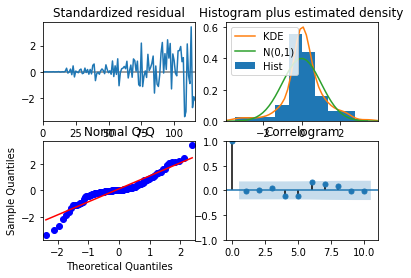

In [44]:
model_s.plot_diagnostics()
plt.show()

In [45]:
concat_df = pd.concat([dates.astype(str), ar_c.astype(int), ar_e.astype(int), diff_g.astype(int), pr_cf.astype(int), pr_ef.astype(int), sar_c.astype(int), sar_e.astype(int)], axis=1)
concat_df.style.set_properties(**{'text-align': 'center'})

,Projection_Dates,ARIMA_Confirmed,ARIMA_Deaths,Diffusion-Confirmed,Diffusion-Deaths,Prophet_Confirmed,Prophet_Deaths,SARIMAX_Confirmed,SARIMAX_Deaths
0,2020-06-23,188856,3800,190569,3660,190324,3699,189224,3799
1,2020-06-24,192674,3906,196823,3771,195528,3793,193407,3900
2,2020-06-25,196397,4012,203201,3884,200731,3890,197557,4001
3,2020-06-26,200101,4116,209705,3999,206247,3993,201720,4102
4,2020-06-27,203780,4220,216335,4116,211280,4088,205883,4202
5,2020-06-28,207416,4323,223092,4234,216295,4182,210044,4301
6,2020-06-29,211029,4426,229974,4355,221364,4281,214206,4400
7,2020-06-30,214612,4528,236984,4478,226383,4369,218368,4499
8,2020-07-01,218163,4630,244120,4602,232106,4470,222530,4597
9,2020-07-02,221688,4732,251384,4729,237356,4576,226691,4694


In [46]:
concat_df.style.background_gradient(cmap="Reds", subset=['ARIMA_Confirmed'])\
               .background_gradient(cmap="Greys", subset=['ARIMA_Deaths'])\
               .background_gradient(cmap="Reds", subset=['Diffusion-Confirmed'])\
               .background_gradient(cmap="Greys", subset=['Diffusion-Deaths'])\
               .background_gradient(cmap='Reds',subset=["Prophet_Confirmed"])\
               .background_gradient(cmap='Greys',subset=["Prophet_Deaths"])\
               .background_gradient(cmap='Reds',subset=["SARIMAX_Confirmed"])\
               .background_gradient(cmap='Greys',subset=["SARIMAX_Deaths"])

,Projection_Dates,ARIMA_Confirmed,ARIMA_Deaths,Diffusion-Confirmed,Diffusion-Deaths,Prophet_Confirmed,Prophet_Deaths,SARIMAX_Confirmed,SARIMAX_Deaths
0,2020-06-23,188856,3800,190569,3660,190324,3699,189224,3799
1,2020-06-24,192674,3906,196823,3771,195528,3793,193407,3900
2,2020-06-25,196397,4012,203201,3884,200731,3890,197557,4001
3,2020-06-26,200101,4116,209705,3999,206247,3993,201720,4102
4,2020-06-27,203780,4220,216335,4116,211280,4088,205883,4202
5,2020-06-28,207416,4323,223092,4234,216295,4182,210044,4301
6,2020-06-29,211029,4426,229974,4355,221364,4281,214206,4400
7,2020-06-30,214612,4528,236984,4478,226383,4369,218368,4499
8,2020-07-01,218163,4630,244120,4602,232106,4470,222530,4597
9,2020-07-02,221688,4732,251384,4729,237356,4576,226691,4694
